In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_e = 'red'
color_i = 'blue'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


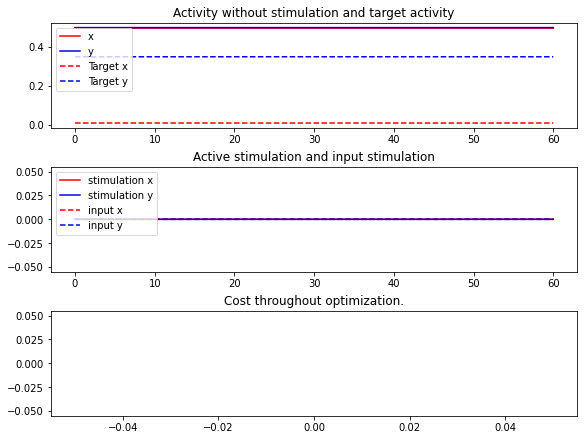

In [58]:
wc = WCModel()
wc.params.sigma_ou = 0.
dt = 0.01

wc.params["dt"] = dt
duration = 60.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control = np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

wc.params["duration"] = duration
x_init = 0.
y_init = 0.
wc.params["exc_init"] = np.array([[x_init]])
wc.params["inh_init"] = np.array([[y_init]])
# bistable region, system goes into down state
down_stimulus = zero_input.copy()
down_stimulus[0,:5000] = -2.
wc.params["exc_ext"] = down_stimulus + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.run()
down_init_e = wc.exc[0,-1]
down_init_i = wc.inh[0,-1]

wc.params["exc_init"] = np.array([[down_init_e]])
wc.params["inh_init"] = np.array([[down_init_i]])
wc.params["exc_ext"] = zero_input + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.run()

target = np.concatenate((np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc.exc, wc.inh), axis=1)), axis=2)

up_stimulus = zero_input.copy()
up_stimulus[0,:5000] = 2.
wc.params["exc_ext"] = up_stimulus + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.run()
up_init_e = wc.exc[0,-1]
up_init_i = wc.inh[0,-1]

wc.params["exc_ext"] = zero_input + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.params["exc_init"] = np.array([[up_init_e]])
wc.params["inh_init"] = np.array([[up_init_i]])
wc.run()


state = np.concatenate( (np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis],
            np.stack( (wc.exc, wc.inh), axis=1)), axis=2) 
plot_oc_singlenode(duration, dt, state, target, np.zeros((target.shape)), np.zeros((target.shape)))

Compute control for a deterministic system
Cost in iteration 0: 1.60000000049674
Cost in iteration 1: 0.5941406305508619
Cost in iteration 2: 0.5797237867903604
Cost in iteration 3: 0.5726687109185808
Cost in iteration 4: 0.5717952645893003
Cost in iteration 5: 0.5715771935893662
Cost in iteration 6: 0.5715226891827133
Cost in iteration 7: 0.5714954931777061
Cost in iteration 8: 0.5714838124563387
Cost in iteration 9: 0.5714596786428102
Cost in iteration 10: 0.5645051536205404
Final cost : 0.5645051536205404


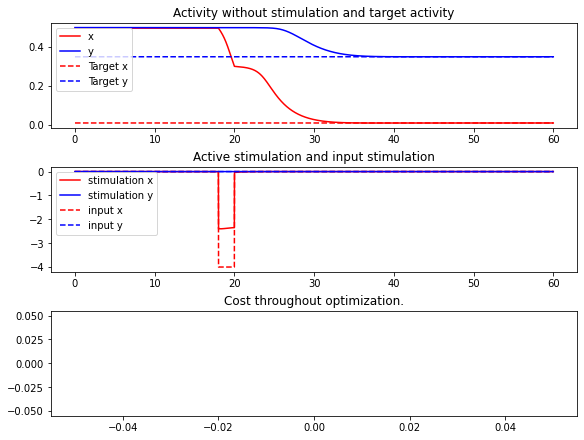

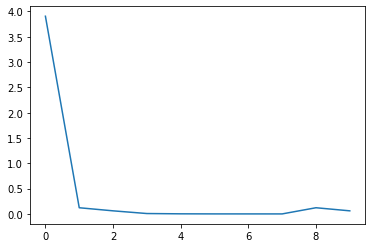

In [62]:
wc.params["exc_ext"] = zero_input + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.params["exc_init"] = np.array([[up_init_e]])
wc.params["inh_init"] = np.array([[up_init_i]])
w2 = 0.1
wp = 1.
precision_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
precision_mat[0,0] = 1.
control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
printarray = np.concatenate( (np.arange(0,101,1), np.arange(200,1001,100)) )
wc_controlled_noisefree = oc_wc.OcWc(wc, target, w_p=wp, w_2=w2, print_array=printarray,
                    control_matrix=control_mat,
                    precision_matrix = precision_mat,
                    precision_cost_interval=(4000,None))

wc_controlled_noisefree.step = 10.

control0 = np.zeros((target.shape))
control0[0,0,1800:2000] = -4.
wc_controlled_noisefree.control = control0.copy()
wc_controlled_noisefree.update_input()
wc_controlled_noisefree.optimize(10)

state = wc_controlled_noisefree.get_xs()
control_noisefree = wc_controlled_noisefree.control

plot_oc_singlenode(duration, dt, state, target, control_noisefree, control0)

plt.plot(wc_controlled_noisefree.step_sizes_history)
plt.show()

In [135]:
controls = []

W2 =  0.02609964657510183
Compute control for a deterministic system
Cost in iteration 0: 0.11065775848276237
Cost in iteration 500: 0.11065670055212251
Cost in iteration 1000: 0.1106565355846754
Final cost : 0.1106565355846754
W2 =  0.2851193555001761
Compute control for a deterministic system
Cost in iteration 0: 1.2088366610203305
Cost in iteration 500: 1.2088327844164988
Cost in iteration 1000: 1.2088319323524295
Final cost : 1.2088319323524295
W2 =  0.17024680222085226
Compute control for a deterministic system
Cost in iteration 0: 0.7218029964542919
Cost in iteration 500: 0.7218022219556349
Cost in iteration 1000: 0.7218016028700436
Final cost : 0.7218016028700436
W2 =  0.3419686224739797
Compute control for a deterministic system
Cost in iteration 0: 1.4498554498854246
Cost in iteration 500: 1.449853907586942
Cost in iteration 1000: 1.4498526810829289
Final cost : 1.4498526810829289


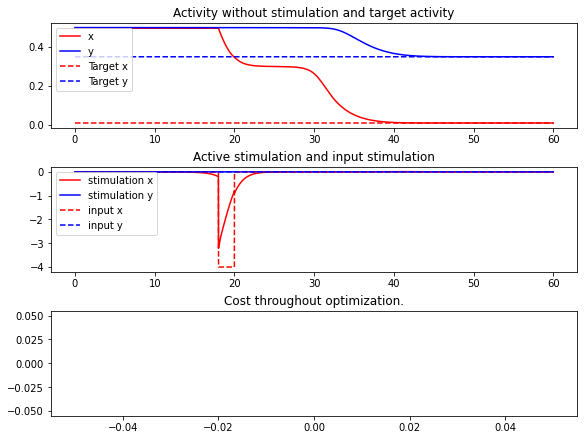

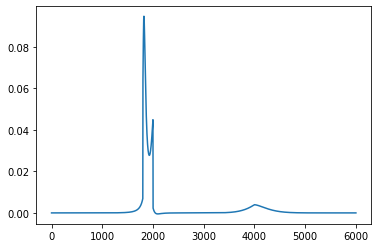

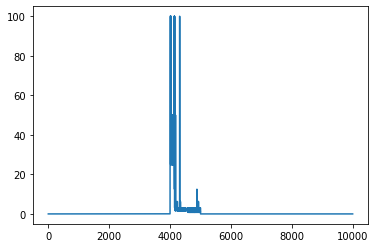

In [144]:
wc_controlled_noisefree.step = 100.
wc_controlled_noisefree.print_array = np.arange(0,1001,500)

for k in range(4):
    wc_controlled_noisefree.w_2 = 0.5 * np.random.random()
    print("W2 = ", wc_controlled_noisefree.w_2)

    wc_controlled_noisefree.optimize(1000)

    controls.append(wc_controlled_noisefree.control)

state = wc_controlled_noisefree.get_xs()
control_noisefree = wc_controlled_noisefree.control

plot_oc_singlenode(duration, dt, state, target, control_noisefree, control0)

grad = wc_controlled_noisefree.grad
plt.plot(grad[0,0,:])
plt.show()

plt.plot(wc_controlled_noisefree.step_sizes_history[-10000:])
plt.show()

In [145]:
save_control = wc_controlled_noisefree.control

In [122]:
wc_controlled_noisefree.control = 1. * save_control
wc_controlled_noisefree.update_input()

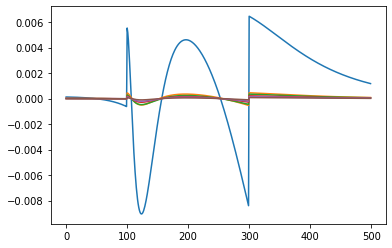

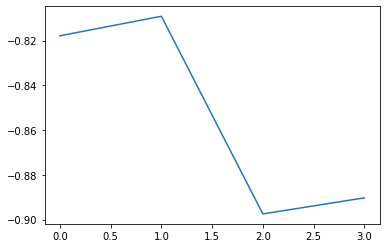

-0.08833856743296531


In [146]:
for c in controls[:-1]:  
    plt.plot(controls[-1][0,0,1700:2200] - c[0,0,1700:2200])
plt.show()

plt.plot(controls[-1][0,0,1998:2002])
plt.show()
print(controls[-1][0,0,2000] - controls[-1][0,0,1999]) # -0.089138